In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
nside=32

In [3]:
import gc

In [4]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

In [5]:
zs=np.linspace(0,1,100)
dNdz = np.ones(zs.shape)
bias = 1*np.ones(len(dNdz))

In [6]:
clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
ell = np.arange(0,6144)
cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

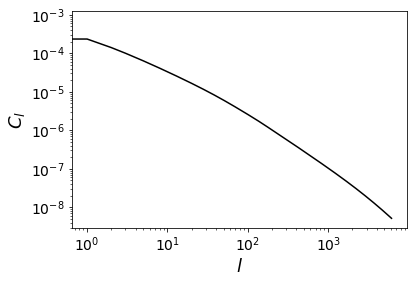

In [7]:
plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_clu, 'k-')
plt.show()

In [8]:
fakeOverdensity = hp.synfast(cls_clu,nside=nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


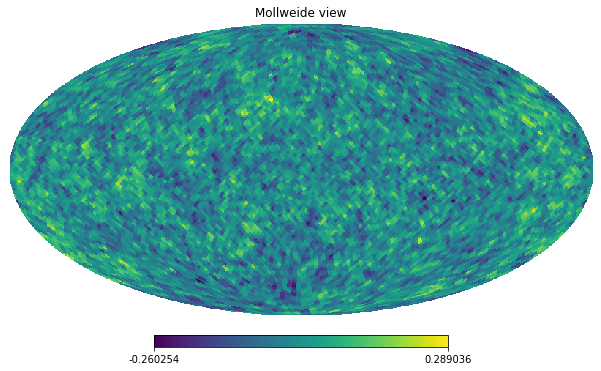

In [9]:
hp.mollview(fakeOverdensity)

# Use kSZ map to get fake kSZ Maps

In [10]:
kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [11]:
kSZPowSpec = hp.anafast(kSZMap)

In [12]:
fakekSZ = hp.synfast(kSZPowSpec,nside=nside)

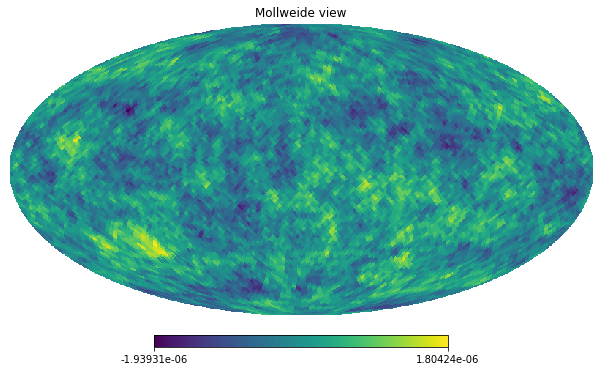

In [13]:
hp.mollview(fakekSZ)

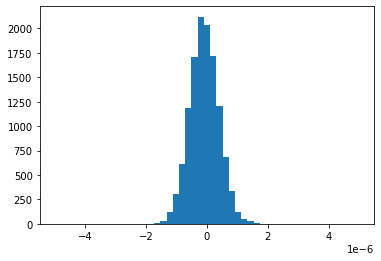

In [14]:
#Need the +1 because a -1 overdensity really means no particles (i.e. overdensity+1 is the value that is directly proportional to mass)
fakeVel = fakekSZ/(fakeOverdensity+1)
plt.hist(fakeVel,bins = np.linspace(-5*10**-6,5*10**-6));

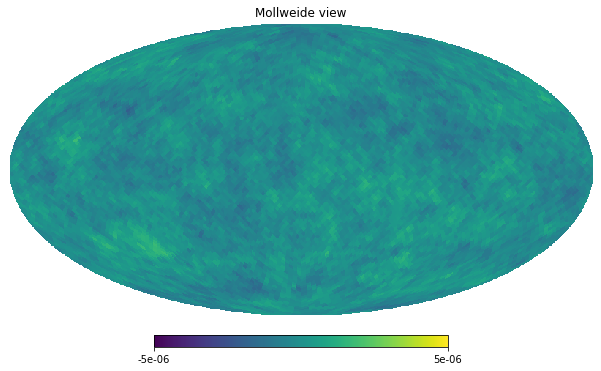

In [15]:
hp.mollview(fakeVel,min = -5*10**-6,max=5*10**-6)

# Make 200 fake maps

In [16]:
import sys

In [17]:
sizeOfOneSet = 3*sys.getsizeof(fakeVel)/(1*10**9)

In [18]:
#This is how many data triplets I can fit in memory
25/sizeOfOneSet

84681.46221174429

In [19]:
numSets = 10000

overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

for i in range(0,numSets):
    overdensData[i] = hp.synfast(cls_clu,nside=nside)
    kSZData[i] = hp.synfast(kSZPowSpec,nside=nside)
    velData[i] = kSZData[i]/(overdensData[i]+1)

In [20]:
from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [21]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,2*12*nside**2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//10])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-numSets//10])

In [22]:
del overdensData
del kSZData
del velData
del x_raw
gc.collect()

0

In [23]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.batch(16)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))                                
dset_train = dset_train.batch(16)

layersMod = [tf.keras.Input(shape=(2*12*nside**2,)),tf.keras.layers.Dense(12*nside**2, activation='relu'),
          # this is a graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # another graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyMonomial(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # a residual layer using graph convolutions
          hp_layer.Healpy_ResidualLayer(layer_type="CHEBY", 
                                        layer_kwargs={"K": 10, "activation": "relu",
                                                      "use_bn": True, "use_bias": True},
                                        use_bn=False,
                                        activation="relu", alpha=0.1),
          tf.keras.layers.Dense(1, activation="sigmoid")
      ]

tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, layers=layersMod,indices=np.arange(0,12*nside**2), n_neighbors=8)

model.build(input_shape=((None,2*12*nside**2), 1))
model.summary(110)

In [25]:
model = models.Sequential()
model.add(tf.keras.Input(shape=(2*12*nside**2,)))
model.add(tf.keras.layers.Dense(12*nside**2, activation='relu'))
model.add(tf.keras.layers.Dense(12*nside**2, activation='relu'))

In [26]:
model.build()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             302002176 
                                                                 
 dense_1 (Dense)             (None, 12288)             151007232 
                                                                 
Total params: 453,009,408
Trainable params: 453,009,408
Non-trainable params: 0
_________________________________________________________________


optimizer = tf.keras.optimizers.Adam(0.1)
loss = tf.keras.losses.MeanSquaredError()
#accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [28]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[r_square])

In [30]:
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test, y_test))

Epoch 1/10
282/282 [==============================] - 270s 955ms/step - loss: 8.5829e-06 - r_square: -15798873.0000 - val_loss: 6.6812e-08 - val_r_square: -123045.3359
Epoch 2/10
282/282 [==============================] - 272s 964ms/step - loss: 9.0075e-10 - r_square: -1670.4376 - val_loss: 6.2063e-08 - val_r_square: -114276.2266
Epoch 3/10
282/282 [==============================] - 270s 958ms/step - loss: 2.8679e-13 - r_square: 0.4673 - val_loss: 6.1996e-08 - val_r_square: -114153.1484
Epoch 4/10
282/282 [==============================] - 271s 962ms/step - loss: 2.8400e-13 - r_square: 0.4726 - val_loss: 6.1996e-08 - val_r_square: -114152.8984
Epoch 5/10
282/282 [==============================] - 275s 976ms/step - loss: 2.8400e-13 - r_square: 0.4723 - val_loss: 6.1996e-08 - val_r_square: -114152.9062
Epoch 6/10
282/282 [==============================] - 261s 927ms/step - loss: 2.8400e-13 - r_square: 0.4725 - val_loss: 6.1996e-08 - val_r_square: -114152.8906
Epoch 7/10
282/282 [========

KeyboardInterrupt: 